In [44]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from random import sample

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
# https://datatofish.com/random-integers-pandas-dataframe/
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofweek.html
# https://stackoverflow.com/questions/29096381/num-day-to-name-day-with-pandas

# https://towardsdatascience.com/how-to-group-data-by-different-time-intervals-using-python-pandas-eb7134f9b9b0
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
# https://www.youtube.com/watch?v=UFuo7EHI8zc
#   ~23:50

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html

# https://stackoverflow.com/questions/4110891/how-to-redirect-the-output-of-print-to-a-txt-file
def write_df_infos(df,filename):
    o = open(filename,'w')
    print(f'df infos for file : {filename}\n', file=o)
    print(f'df.shape : \n{df.shape}\n', file=o)
    print(f'df.head() : \n{df.head()}\n', file=o)
    print(f'df.max() : \n{df.max()}\n', file=o)
    print(f'df.min() : \n{df.min()}\n', file=o)
    print(f'df.info() : \n{df.info()}\n', file=o)
    print(f'df.dtypes : \n{df.dtypes}\n', file=o)
    print(f'df.memory_usage() : \n{df.memory_usage()}\n', file=o)
    print(f'df.nunique() : \n{df.nunique()}\n', file=o)
    o.close()

In [22]:
## 001 ##
# functions to create n months's worth of dummy time data of parking sensor bays

'''
endTime = "2021-09-02 15:01:23"
fq = "15min"  # or 'H' for hourly, 'D' for daily
per = 3*30*24*4  # ~3mth x 30 days x 24 hours x 4(15min)
recordsPerTimeStamp = 3  # number of records per timestamp (akin to number of selected parking sensors)
bayFr, bayTo = 998, 1028  # bay_id range to be randomly draw from
'''

def simParkSensorData1(endTime, fq, per, recordsPerTimeStamp, bayFr, bayTo):
    w = pd.Series(pd.date_range(end=endTime, periods=per, freq=fq))
    lst = []
    for i in range(recordsPerTimeStamp):
        a = pd.Series(np.random.randint(bayFr,bayTo,size=len(w)))
        aw = pd.concat([a,w], axis='columns')
        lst.append(aw)

    _df = pd.concat(lst, axis='index')
    _df.columns = ['bay_id','db_read_time']
    _df = _df.drop_duplicates().reset_index(drop=True)

    _df['status'] = np.random.randint(0,2,size=len(_df))
    _df['status'] = _df['status'].replace({0:"Unoccupied", 1:"Present"})
    _df = _df.sort_values(by=['db_read_time','bay_id'])
    
    print(f'''Generated {_df["db_read_time"].count()} records in \
        {_df["db_read_time"].nunique()} time periods over \
        {_df["db_read_time"].dt.date.nunique()} days \
        (frequency of time period = {fq}).''')
          #.format(_df["db_read_time"].count(),_df["db_read_time"].nunique(),_df["db_read_time"].dt.date.nunique()))
     
    # _df.to_csv("datasets/simulatedTimeData_IncompleteParkingSensors.csv", index=False)
    return _df

def simParkSensorData2(endTime, fq, per, bayFr, bayTo):
    w = pd.Series(pd.date_range(end=endTime, periods=per, freq=fq))
    lst = []
    for i in range(bayTo+1-bayFr):
        a = pd.Series(np.repeat((bayFr+i),len(w)))
        aw = pd.concat([a,w], axis='columns')
        lst.append(aw)

    _df = pd.concat(lst, axis='index')
    _df.columns = ['bay_id','db_read_time']
#     _df = _df.drop_duplicates()

    _df['status'] = np.random.randint(0,2,size=len(_df))
    _df['status'] = _df['status'].replace({0:"Unoccupied", 1:"Present"})
    _df = _df.sort_values(by=['db_read_time','bay_id']).reset_index(drop=True)
    
    print(f'''Generated {_df["db_read_time"].count()} records in \
        {_df["db_read_time"].nunique()} time periods over \
        {_df["db_read_time"].dt.date.nunique()} days \
        (frequency of time period = {fq}).''')
          #.format(_df["db_read_time"].count(),_df["db_read_time"].nunique(),_df["db_read_time"].dt.date.nunique()))
     
    # _df.to_csv("datasets/simulatedTimeData_CompleteParkingSensors.csv", index=False)
    return _df

In [156]:
def genPSdata(endTime, fq, period, bayFr, bayTo, dropRate=0):
    """Generate random status for a specified range of parking bays over specified period of time.
    Options are provided to specify frequency (fq) of time interval of status reads,
    and a dropRate to specify a portion of records to be dropped randomly to simulate what we observed in real data.

    Args:
        endTime (date time string): end time of specified period (e.g. "2021-09-02 15:01:23")
        fq (string): specifies time interval between status reads (e.g. "15min")
        period (integer): number of fq time intervals (e.g. for fq="15min", 4*24*7 is for one week's data at 15min intervals)
        bayFr (integer): lower range of specified bay ids
        bayTo (integer): upper range of specified bay ids
        dropRate (int, optional): Defaults to 0. This is portion (between 0 and 1) of data to drop by random sample

    Returns:
        pandas dataframe: of randomly generated status data as specified by the parameters
    """    
    w = pd.Series(pd.date_range(end=endTime, periods=period, freq=fq))
    baysList = list(range(bayFr,(bayTo+1)))
    randomisedBaysList = sample(baysList, k=len(baysList))
    lst = []
    for bay in randomisedBaysList:
        a = pd.Series(np.repeat((bay),len(w)))
        aw = pd.concat([a,w], axis='columns')
        aw = aw.sample(frac=(1-dropRate))
        lst.append(aw)

    _df = pd.concat(lst, axis='index')
    _df.columns = ['bay_id','db_read_time']

    _df['status'] = np.random.randint(0,2,size=len(_df))
    _df['status'] = _df['status'].replace({0:"Unoccupied", 1:"Present"})
    _df = _df.sort_values(by=['db_read_time']).reset_index(drop=True)
    
    startdt = _df['db_read_time'].min()
    enddt = _df['db_read_time'].max()
    print(f"Generated {_df.db_read_time.count()} records between {startdt} and {enddt}")
    print(f"(with drop rate of {dropRate}, to simulate missing status records in real data).")
    print(f"There are {_df.db_read_time.nunique()} time periods over {_df.db_read_time.dt.date.nunique()} days")
    print(f"(frequency of time period = {fq}).")

    return _df

In [157]:
## 001a ##
# test function here

df = genPSdata(endTime="2021-09-02 15:01:23", fq="15min", period=(3*30*24*4), bayFr=995, bayTo=4502, dropRate=0.7)
df.head(20)

Generated 9092736 records between 2021-06-04 15:16:23 and 2021-09-02 15:01:23
(with drop rate of 0.7, to simulate missing status records in real data).
There are 8640 time periods over 91 days
(frequency of time period = 15min).


,bay_id,db_read_time,status
0,1381,2021-06-04 15:16:23,Unoccupied
1,1501,2021-06-04 15:16:23,Unoccupied
2,1002,2021-06-04 15:16:23,Unoccupied
3,1824,2021-06-04 15:16:23,Unoccupied
4,3570,2021-06-04 15:16:23,Present
5,2586,2021-06-04 15:16:23,Present
6,3704,2021-06-04 15:16:23,Unoccupied
7,3540,2021-06-04 15:16:23,Present
8,1516,2021-06-04 15:16:23,Present
9,3770,2021-06-04 15:16:23,Present


In [6]:
## 002 ##
# input is list of bay ids and ETL dataframe
# output is time records from ETL dataframe that matches match the input list if bay ids

def filter_bayRec_from_ETL(bay_ids_lst, etl_df):
    return etl_df[etl_df['bay_id'].isin(bay_ids_lst)]

In [129]:
dfs['db_read_time'] = pd.to_datetime(dfs["db_read_time"])

In [130]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83096 entries, 0 to 83095
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   st_marker_id  83096 non-null  object        
 1   status        83096 non-null  object        
 2   db_read_time  83096 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 1.9+ MB


In [23]:
## 002a ##
# test function here

df_filtered = filter_bayRec_from_ETL([999,1000],df)
df_filtered.head()

,bay_id,db_read_time,status
0,999,2021-03-06 15:16:23,Present
1,1000,2021-03-06 15:16:23,Present
4,999,2021-03-06 15:31:23,Unoccupied
5,1000,2021-03-06 15:31:23,Unoccupied
8,999,2021-03-06 15:46:23,Unoccupied


In [119]:
## 003 ##
# input is dataframe, and time parameters that has defaults
# outputs aggregated data (average status counts in a bin)
# apart from average, can change aggregated data to give median/min/max 

def last_hrs(_df, no_hrs=24, bin_size_mins='15min', endDatetime=datetime.now()):
    dfpv = pd.pivot_table(_df, index="db_read_time", columns="status", aggfunc='count')
    dfpv = dfpv.fillna(0)
    dfpv.columns = ["P","U"]

    startDatetime = endDatetime - timedelta(hours=no_hrs)
    dfpv = dfpv.loc[startDatetime : endDatetime]  # filter between specified times
    
    aa = dfpv['P'].resample(bin_size_mins).mean()  # average number of occuppied sensors out of these filtered set of sensors
    bb = dfpv['U'].resample(bin_size_mins).mean()
    
    df = pd.concat([aa,bb], axis='columns')
    df.columns = ['Present','Unoccupied']
    df.index.name = 'time interval'
    return df

In [153]:
## 003a flexible time interval resample stats function ##
def timeIntStats(df, startdt, enddt, bin="15min", bin_stat="median", tindex="db_read_time"):
    """Takes a dataframe of periodically read (assume every 15min) status data of parking sensors,
    then filters it based on supplied start and end date times,
    then resamples  this filtered data using supplied bin size for the specified bin statistic.
    The timestamp column name of the input dataframe can be specified (if different from the default).

    Args:
        df (pandas dataframe): of periodically read (assume read at 15min intervals) status data of parking sensors
        startdt (date time string): "yyyy-mm-dd HH:MM:SS" (e.g. "2021-08-28 15:00:00")
        enddt (date time string): "yyyy-mm-dd HH:MM:SS" (e.g. "2021-08-28 15:00:00")
        bin (str, optional): Defaults to "15min". Other appropriate values are "1H", "1D", "1W", "1M"
        bin_stat (str, optional): Defaults to "median". Other optons are "mean", "min", "max", "count"
        tindex (str, optional): Defaults to "db_read_time".

    Returns:
        pandas dataframe: that is a pivot table of the original df, time filtered, and resampled for specified statistics
    """    
    df[tindex] = pd.to_datetime(df[tindex])
    dfpv = pd.pivot_table(df, index=tindex, columns="status", aggfunc='count')
    dfpv = dfpv.fillna(0)
    dfpv.columns = ["P","U"]

    dfpv = dfpv.loc[startdt : enddt]  # filter between specified date times
    
    if bin_stat=='median':
        aa = dfpv['P'].resample(bin).median()  
        bb = dfpv['U'].resample(bin).median()
    elif bin_stat=='mean':
        aa = dfpv['P'].resample(bin).mean()  
        bb = dfpv['U'].resample(bin).mean()
    elif bin_stat=='min':
        aa = dfpv['P'].resample(bin).min()  
        bb = dfpv['U'].resample(bin).min()
    elif bin_stat=='max':
        aa = dfpv['P'].resample(bin).max()  
        bb = dfpv['U'].resample(bin).max()
    elif bin_stat=='count':
        aa = dfpv['P'].resample(bin).count()  
        bb = dfpv['U'].resample(bin).count()
    else:
        ValueError: print("Invalid 'bin_stat' parameter entered !!")
    # NOTE that I did not include .sum() as we may be resampling
    # (e.g. 4x 15min intervals resample under 1x 60min interval, and it's inappropriate to sum in that case)
    # The .count() included as more of a check the records in a time interval, it shouldn't be used like mean or median
    
    df = pd.concat([aa,bb], axis='columns')
    df.columns = ['Present','Unoccupied']
    df.index.name = 'time_interval'

    ## can add below columns to help visualisation labeling (also re-index, but index need to be unique)
    # df['year'] = df.index.year
    # df['qtr'] = df.index.quarter
    # df['mth'] = df.index.month
    # df['wk'] = df.index.week  # week ordinal of the year
    # df['dayOfWk'] = df.index.dayofweek  # day of week, 0=Mon, 6=Sun
    # df['dayOfMth'] = df.index.day  # day of month
    # df['dayOfYr'] = df.index.dayofyear
    
    return df

In [154]:
## 003b to test function above
dfs1 = timeIntStats(dfs, "2021-08-28 00:00:00", "2021-08-28 15:00:00", bin="1H", bin_stat="median")
dfs1

,Present,Unoccupied
time_interval,,
2021-08-28 00:00:00,171.5,873.0
2021-08-28 01:00:00,164.0,812.0
2021-08-28 02:00:00,161.0,818.5
2021-08-28 03:00:00,158.5,827.0
2021-08-28 04:00:00,163.5,823.5
2021-08-28 05:00:00,169.0,819.0
2021-08-28 06:00:00,226.5,762.5
2021-08-28 07:00:00,303.5,694.5
2021-08-28 08:00:00,375.5,631.0


In [121]:
## 003z ##
# test function here

df_lasthours = last_hrs(dfs,24,'15min')
df_lasthours

In [16]:
## 004 ##
# input is dataframe, and time parameters that has defaults
# outputs aggregated data (average status counts in a bin)
# apart from average, can change aggregated data to give median/min/max 

def last_mdays(_df, no_days=30, bin_size_mins='60min', endDatetime=datetime.now()):
    dfpv = pd.pivot_table(_df, index="db_read_time", columns="status", aggfunc='count')
    dfpv = dfpv.fillna(0)
    dfpv.columns = ["P","U"]

    startDatetime = endDatetime - timedelta(days=no_days)
    dfpv = dfpv.loc[startDatetime : endDatetime]  # filter between specified times
    
    aa = dfpv['P'].resample(bin_size_mins).median()  # average number of occuppied sensors out of these filtered set of sensors
    bb = dfpv['U'].resample(bin_size_mins).median()
    df = pd.concat([aa,bb], axis='columns')
    df.columns = ['Present','Unoccupied']
    df.index.name = 'time interval'
    return df

In [25]:
## 004a ##
# test function here

df_lastdays = last_mdays(df,5,'60min')
df_lastdays

,Present,Unoccupied
time interval,,
2021-08-07 13:00:00,3.0,1.0
2021-08-07 14:00:00,2.5,1.5
2021-08-07 15:00:00,1.5,2.5
2021-08-07 16:00:00,2.0,2.0
2021-08-07 17:00:00,1.0,3.0
...,...,...
2021-08-12 09:00:00,2.5,1.5
2021-08-12 10:00:00,2.5,1.5
2021-08-12 11:00:00,2.0,2.0


In [7]:
## 005 ##
# input is dataframe, and time parameters that has defaults
# outputs aggregated data (average status counts in a bin)
# apart from average, can change aggregated data to give median/min/max 

def last_periods(_df, no_days=60, bin_period='W-MON', endDatetime=datetime.now()):
    dfpv = pd.pivot_table(_df, index="db_read_time", columns="status", aggfunc='count')
    dfpv = dfpv.fillna(0)
    dfpv.columns = ["P","U"]

    startDatetime = endDatetime - timedelta(days=no_days)
    dfpv = dfpv.loc[startDatetime : endDatetime]  # filter between specified times
    
    aa = dfpv['P'].resample(bin_period).mean()  # average number of occuppied sensors out of these filtered set of sensors
    bb = dfpv['U'].resample(bin_period).mean()
    df = pd.concat([aa,bb], axis='columns')
    df.columns = ['Present','Unoccupied']
    df.index.name = 'time interval'
    return df

In [8]:
## 005a ##
# test function here

df_lastweeks = last_periods(df,60,'D')
df_lastweeks

,Present,Unoccupied
time interval,,
2021-06-13,1.947368,2.052632
2021-06-14,2.114583,1.885417
2021-06-15,1.947917,2.052083
2021-06-16,1.947917,2.052083
2021-06-17,1.906250,2.093750
...,...,...
2021-08-08,1.958333,2.041667
2021-08-09,2.187500,1.812500
2021-08-10,2.187500,1.812500


In [27]:
## 005b ##
# test function here

df_lastmonths = last_periods(df,60,'MS')
df_lastmonths

,Present,Unoccupied
time interval,,
2021-06-01,1.989241,2.010759
2021-07-01,2.015457,1.984543
2021-08-01,1.981098,2.018902


<AxesSubplot:xlabel='time interval'>

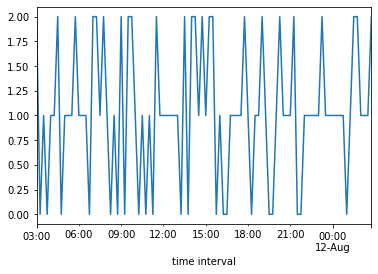

In [494]:
df_lasthours['Present'].plot()

In [28]:
## 006
# filter on particular weekdays (e.g. Mondays over the periods in dataframe)
# input is dataframe with datetime index, and a list of days of week we want filtered
# dow is list of weekdays : 0=Monday .. 6=Sunday

def dayOfWeek_timeData(_df, dow):
    df = _df[_df.index.dayofweek.isin(dow)]
    df["timeInterval"] = df.index
    df = df.set_index(df.index.isocalendar().week)
    return df

In [9]:
df_lastweeks.head()

,Present,Unoccupied
time interval,,
2021-06-13,1.947368,2.052632
2021-06-14,2.114583,1.885417
2021-06-15,1.947917,2.052083
2021-06-16,1.947917,2.052083
2021-06-17,1.906250,2.093750


/home/honalbert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


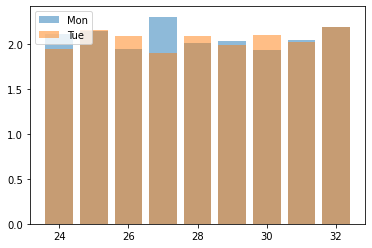

In [42]:
## 006a
# test function
# 0=Monday .. 6=Sunday

mon = dayOfWeek_timeData(df_lastweeks,[0])
tue = dayOfWeek_timeData(df_lastweeks,[1])
wed = dayOfWeek_timeData(df_lastweeks,[3])
# mon_sun = dayOfWeek_timeData(df_lastweeks,[0,6])

plt.bar(mon.index, mon['Present'],alpha=0.5)
plt.bar(tue.index, tue['Present'],alpha=0.5)
plt.legend(labels=['Mon','Tue'])

In [33]:
mon.head(3)

,Present,Unoccupied,timeInterval
week,,,
24,2.114583,1.885417,2021-06-14
25,2.145833,1.854167,2021-06-21
26,1.947917,2.052083,2021-06-28


In [34]:
tue.head(3)

,Present,Unoccupied,timeInterval
week,,,
24,1.947917,2.052083,2021-06-15
25,2.156250,1.843750,2021-06-22
26,2.083333,1.916667,2021-06-29


In [28]:
# "102_4n3a-s6rn_dl_at__20210731.cvs"
# !head -10 102_4n3a-s6rn_dl_at__20210731.csv

cols = ['ArrivalTime', 'DepartureTime', 'StreetMarker']

# ~990 MB csv, too big to read in once, do read in chunks
data_iter = pd.read_csv("datasets/102_4n3a-s6rn_dl_at__20210731.csv", usecols=cols, chunksize=100000, nrows=3000000)

# create desired output df structure while reading in chunks of csv
# (that is to convert each row of arrive and depart times, to 2 status rows of [1] to Present time [2] to Unoccupied time) 
chunks = []
for chunk in data_iter:
    # df1 for parking bay status to 'Unoccupied'
    df1 = chunk.drop(columns='DepartureTime').rename(columns={'ArrivalTime':'statusChgAt'})
    df1['status'] = "Present"
    # df2 for parking bay status to 'Present'
    df2 = chunk.drop(columns='ArrivalTime').rename(columns={'DepartureTime':'statusChgAt'})
    df2['status'] = "Unoccupied"

    df = pd.concat([df1,df2], axis='index')
    # df['BayId'] = df['BayId'].astype(int)
    df['statusChgAt'] = pd.to_datetime(df['statusChgAt'])
    df = df.sort_values(by='statusChgAt', ascending=True)
    df = df.reset_index()
    df = df.dropna()
    chunks.append(df)

df_ = pd.concat(chunks, axis='index')
df_.to_csv('datasets/102_4n3a-s6rn__convertedToStatus.csv', index=False)

write_df_infos(df_, 'datasets/102_4n3a-s6rn__convertedToStatus.txt')

/home/honalbert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: null_counts is deprecated. Use show_counts instead


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000000 entries, 42380 to 2903929
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   statusChgAt   6000000 non-null  datetime64[ns]
 1   StreetMarker  6000000 non-null  object        
 2   status        6000000 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 183.1+ MB


In [36]:
df_ = df_.drop(columns='index')

In [38]:
df_.nunique()

statusChgAt     2227946
StreetMarker       2045
status                2
dtype: int64

In [31]:
df_ = df_.reset_index()


In [39]:
# https://www.youtube.com/watch?v=tcRGa2soc-c&t=802s

dfm = df_.set_index(['StreetMarker','statusChgAt'])
dfm.sort_index(inplace=True)


In [58]:
m2392N = df_[df_['StreetMarker']=='2392N']

In [48]:
m2392N.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2004 entries, 0 to 825754
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   statusChgAt   2004 non-null   datetime64[ns]
 1   StreetMarker  2004 non-null   object        
 2   status        2004 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 62.6+ KB


/home/honalbert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [49]:
m2392N.describe()

/home/honalbert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,statusChgAt,StreetMarker,status
count,2004,2004,2004
unique,1013,1,2
top,2020-01-13 09:11:14,2392N,Present
freq,3,2004,1002
first,2020-01-01 00:00:00,NaN,NaN
last,2020-01-18 02:16:05,NaN,NaN


In [51]:
m2392N['status'] = m2392N['status'].replace({'Present':1, 'Unoccupied':0})

/home/honalbert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [54]:
m2392N = m2392N.drop(columns='StreetMarker').set_index('statusChgAt')